In [ ]:
library(data.table)
library(forecastML)
library(tidyverse)
library(lubridate)
library(caret)
library(zoo)
options(repr.plot.width=15)
options(repr.plot.height=8)

In [51]:
x2017 <- fread('~/hakmar/2017.csv',dec = '.')
x2018 <- fread('~/hakmar/2018.csv',dec = '.')
x2019 <- fread('~/hakmar/2019.csv',dec = '.')
x2020 <- fread('~/hakmar/2020.csv',dec = '.')
x2021 <- fread('~/hakmar/2021.csv',dec = '.')
colname <- fread('~//hakmar_fulldata.csv',nrows = 1)
data <- list(x2017,x2018,x2019,x2020,x2021) %>% rbindlist
colnames(data) <- names(colname)[2:11]
ozel_gun_anlam <- fread('~/hakmar/Ozel_gunler.csv')
stok <- fread('~//hakmar/Stoklar.csv') %>% mutate(stok_kodu=V1,urun=paste(V17,V2)) %>% select(stok_kodu,urun)

In [53]:
kategorize <- function(x){
    if(grepl('ANTEP',x)) return('Antep Fistigi')
    if(grepl('BADEM',x)) return('Badem')
    if(grepl('FINDIK',x)) return('Findik')
    if(grepl('UZUM',x)) return('Uzum')
    if(grepl('LEBLEB',x)) return('Leblebi')
    if(grepl('CEVI',x)) return('Ceviz')
    if(grepl('FISTI',x)) return('Fistik')
    if(grepl('CEKIRDE',x)) return('Cekirdek')
    if(grepl('KARISI',x) | grepl('MIX',x)| grepl('KOKTEY',x)| grepl('MEYVELE',x)) return('Karisik')
    if(grepl('INCIR',x)) return('Incir')
    if(grepl('KAYIS',x)) return('Kayisi')
    if(grepl('GUN KURUS',x)) return('Gun Kurusu')
    if(grepl('NUTZZ',x)) return('Yer Fistigi')
    if(grepl('KURU',x)) return('Kurutulmus Meyve')
    if(grepl('CITLIY',x)) return('Cekirdek')
    if(grepl('HURMA',x)) return('Hurma')
    if(grepl('KAJU',x)) return('Kaju')
    if(grepl('MANGO',x)) return('Mango')
    if(grepl('BAR',x) | grepl('NESFIT',x)) return('Bar')
    if(grepl('KECI BOY',x)) return('Keci Boynuzu')
    if(grepl('MISIR',x)) return('Misir')
    if(grepl('LOKUM',x) | grepl('KOME',x)| grepl('TATLIS',x)| grepl('BALLI',x) ) return('Hazir Tatlilar')
}

In [55]:
stok  %>% mutate(kategori= apply(stok %>% select(urun),1,kategorize)) -> kategorized_urun

In [154]:
hava <- fread('~/hakmar/temp.csv')
yagmur1 <- fread('~/hakmar/yagmur.csv')
yagmur2 <- fread('~/hakmar/yagmur2.csv')
colnames(yagmur2) <- c('tarih','.xxxx','.xxx','.xx','.x','yagmur')

yagmur1 <- yagmur1 %>%
rename(tarih=date,yagmur=rain_drizzle) %>%
select(tarih,yagmur)

yagmur2 <- yagmur2 %>%
select(tarih,yagmur) %>%
mutate(tarih=as.Date(tarih,'%m/%d/%y')) %>% 
mutate(yagmur=gsub('[^0-9.]','',yagmur)) %>% 
mutate(yagmur=as.numeric(yagmur)) %>% 
mutate(yagmur=as.integer(ifelse(yagmur>0,1,0)))%>%
mutate(yagmur=na.approx(yagmur)) %>% 
mutate(yagmur=as.integer(ifelse(yagmur>0,1,0)))%>% 
rbind(data.table(tarih=as.Date('2017-01-01'),yagmur=0)) -> yagmur2

max(yagmur1$tarih) + 1 -> max_date
yagmur2 <- yagmur2 %>% filter(tarih>=max_date)

rbind(yagmur1 %>% mutate(tarih=as.Date(tarih)),yagmur2) %>% 
rbind(data.table(tarih=as.Date('2017-01-01'),yagmur=0)) -> yagmur

hava %>%
select(DATE,TAVG) %>%
rename(tarih=DATE,ort_sicaklik=TAVG) %>%
mutate(tarih=as.Date(tarih),ort_sicaklik=fahrenheit.to.celsius(ort_sicaklik)) -> hava

In [304]:
data %>%
mutate(tarih=ymd_hms(tarih)) %>%
left_join(kategorized_urun,by='stok_kodu') %>%
mutate(tur=ifelse(grepl('ACIK',urun),'Acik','Paket')) %>% 
select(-urun) %>% 
mutate(arife=ifelse(ozel_gun==2 | ozel_gun==1,1,0),yilbasi=ifelse(ozel_gun==6,1,0),asure=ifelse(ozel_gun==4,1,0)) %>% 
select(-c(stok_kodu,ozel_gun)) %>% 
group_by(magaza_no,tarih,kategori,tur) %>%
summarise(top_insert=sum(insert),
          top_teshir=sum(teshir),
          arife=ifelse(sum(arife)>0,1,0),
          asure=ifelse(sum(asure)>0,1,0),
          yilbasi=ifelse(sum(yilbasi>0),1,0),
          toplam_satis_miktari=sum(satis_miktari),
          toplam_satis_tutari=sum(satis_tutari)) %>% 
ungroup %>% 
mutate(hafta_gun=wday(tarih),hafta_yil=isoweek(tarih),ay=month(tarih),yil=year(tarih)) %>% 
mutate(trend=ifelse(hafta_yil>40 & hafta_yil<=52,hafta_yil-39,0)) %>%
left_join(yagmur,by='tarih') %>% 
left_join(hava,by='tarih') -> data_

data_ %>%
select(tarih,asure) %>%
filter(asure==1) %>%
select(tarih) %>%
unique %>% 
as.data.table %>%  
slice(rep(1:n(),30)) %>% 
group_by(tarih) %>%
mutate(sira=1:n()) %>% 
ungroup %>% 
mutate(sira=sira-1) %>% 
mutate(tarih=as.Date(tarih)+sira) %>% 
group_by(tarih) %>% 
mutate(asure_trend=-sira-1) %>% 
select(-sira) %>% 
ungroup -> asure_trend_dt 

data_ <- data_ %>% left_join(asure_trend_dt,by='tarih') %>% mutate(asure_trend=ifelse(is.na(asure_trend),0,asure_trend))

`summarise()` has grouped output by 'magaza_no', 'tarih', 'kategori'. You can override using the `.groups` argument.



In [305]:
data_ %>%
keep(is.numeric) %>% 
select(-magaza_no) %>%
cor %>% 
melt %>% 
mutate(value=abs(value)) %>% 
arrange(value) %>% head(30) %>% 
select(Var1) %>%
pull %>%
as.vector %>% 
unique -> model_variables

model_variables

[1] "hafta_gun"            "top_teshir"           "asure"               
 [4] "asure_trend"          "arife"                "toplam_satis_miktari"
 [7] "hafta_yil"            "ay"                   "top_insert"          
[10] "yilbasi"              "toplam_satis_tutari"

In [363]:
formula_ <- 'toplam_satis_miktari ~ as.factor(asure) + yilbasi +
top_teshir + top_insert + trend + hafta_gun + ay + hafta_yil + ort_sicaklik + 
as.factor(yagmur) + as.factor(magaza_no)  + asure_trend +
as.factor(tur)' %>% as.formula

In [364]:
data2_ <- data_ %>% filter(yil==2017 | yil==2018) %>% filter(kategori=='Cekirdek')

In [365]:
linear_model <- lm(formula_,data2_) 
linear_model %>% summary


Call:
lm(formula = formula_, data = data2_)

Residuals:
    Min      1Q  Median      3Q     Max 
-85.101 -12.740  -2.995   9.132 258.272 

Coefficients:
                         Estimate Std. Error t value             Pr(>|t|)    
(Intercept)              34.07478    0.69310  49.163 < 0.0000000000000002 ***
as.factor(asure)1        15.41246    2.08352   7.397 0.000000000000142011 ***
yilbasi                  89.24979    3.78585  23.575 < 0.0000000000000002 ***
top_teshir                4.97618    0.66277   7.508 0.000000000000061383 ***
top_insert                7.99731    0.26654  30.004 < 0.0000000000000002 ***
trend                     0.83489    0.07744  10.781 < 0.0000000000000002 ***
hafta_gun                -0.21570    0.05470  -3.944 0.000080392511544326 ***
ay                        1.11102    0.21235   5.232 0.000000168610411147 ***
hafta_yil                -0.47439    0.05187  -9.145 < 0.0000000000000002 ***
ort_sicaklik              0.15085    0.02839   5.314 0.00000010765

In [326]:
library(broom)
linear_model %>% tidy %>% mutate(p.value=round(p.value,2))

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),2.74825744,0.186958997,14.6997871,0.00
as.factor(asure)1,19.97295183,0.466196056,42.8423870,0.00
yilbasi,20.49683052,0.872740845,23.4855864,0.00
top_teshir,-2.51735650,0.235040787,-10.7102964,0.00
top_insert,14.21971003,0.072764529,195.4209026,0.00
trend,0.22214727,0.018428170,12.0547657,0.00
hafta_gun,-0.03261284,0.013041090,-2.5007758,0.01
ay,0.28228570,0.052473914,5.3795435,0.00
hafta_yil,-0.14100974,0.012758185,-11.0524923,0.00


In [358]:
data_ %>% 
filter(yil==2017,magaza_no==5,kategori=='Cekirdek') -> sample

`summarise()` has grouped output by 'hafta_yil'. You can override using the `.groups` argument.



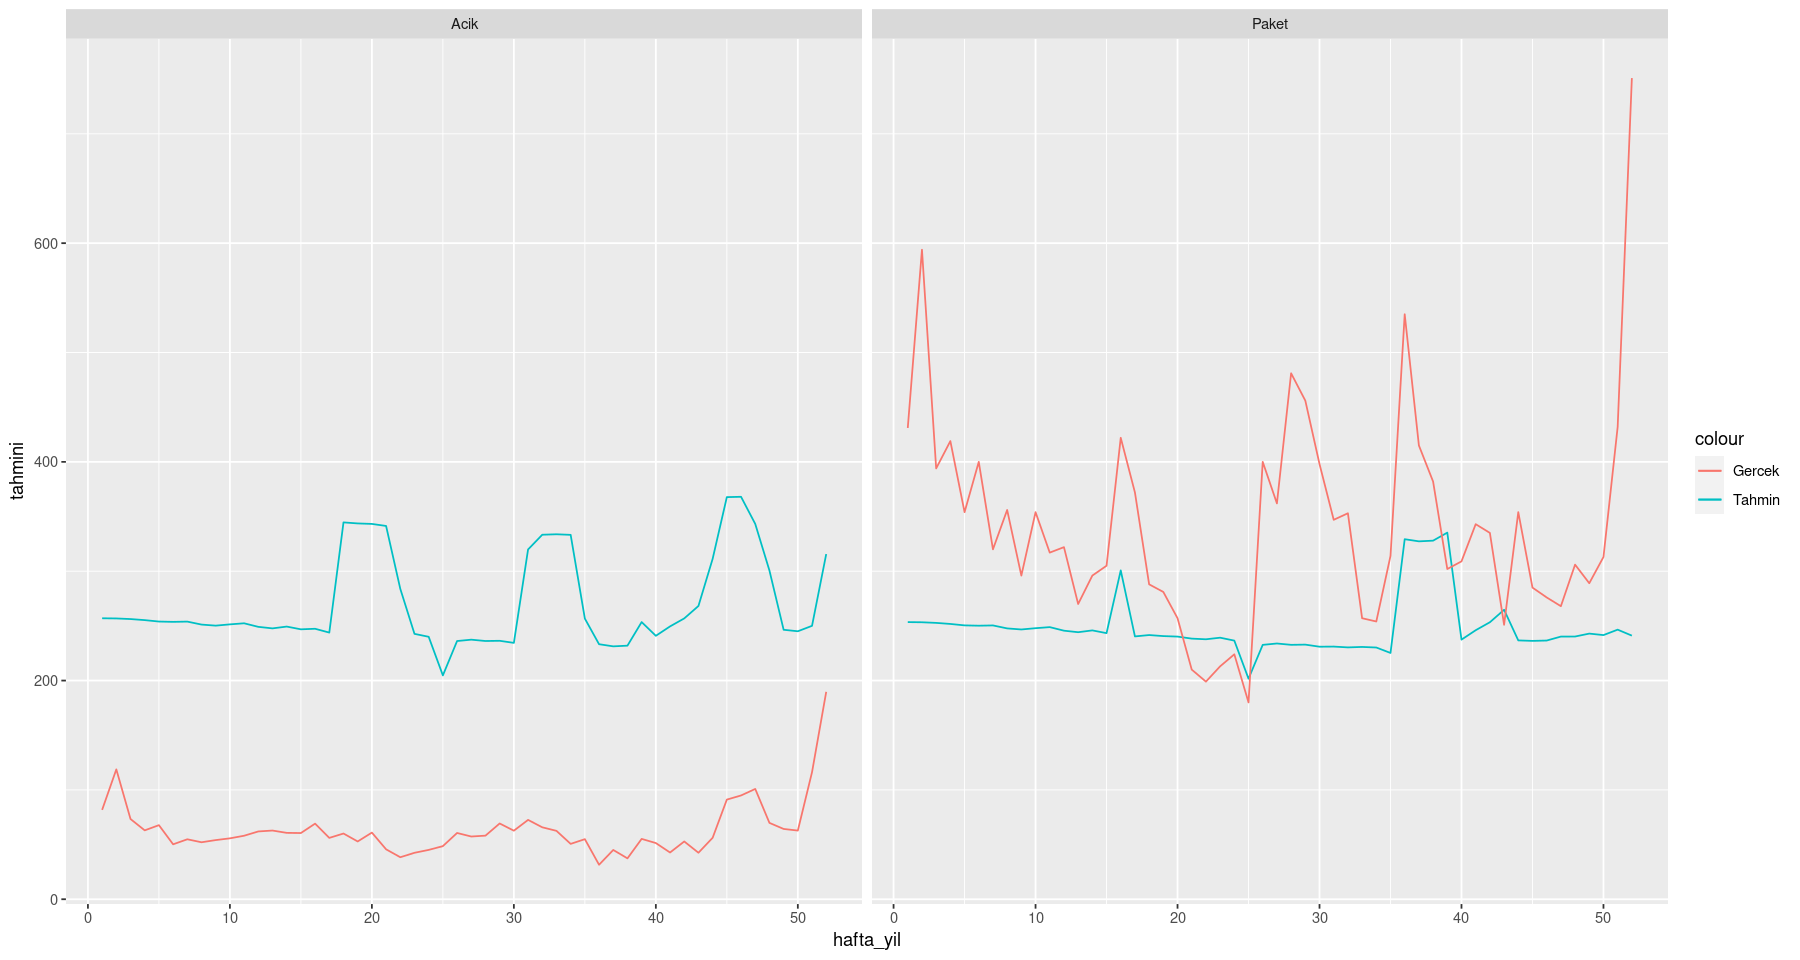

In [359]:
pred <- predict(linear_model,sample)
sample %>%
cbind(pred) %>% 
group_by(hafta_yil,tur) %>%
summarise(tahmini=sum(pred,na.rm=T),gercek=sum(toplam_satis_miktari)) %>% 
ggplot(aes(x=hafta_yil))+
geom_line(aes(y=tahmini,color='Tahmin'))+
geom_line(aes(y=gercek,color='Gercek'))+
facet_wrap(~tur)